## Лабораторна робота 1. Ймовірнісні та геометричні методи виявлення аномалій

Ми дізнаємося, що аномалії є викидами в даних, які заслуговують на подальше вивчення. 
Ми обговоримо основні методи оцінки для виявлення викидів.

Ми будемо шукати аномалії в одновимірних та багатовимірних даних. Ми будемо використовувати як z-оцінки, так і модифіковані z-оцінки.Розглянемо сильні сторони та недоліки обох підходів.

Ми будемо шукати аномалії користуючись тестом Граббса.

Ми використаїмо відстань Махалонобіса для знаходження аномалій в багатовимірних даних.


## Результати навчання
Ви повинні:

1) Розуміння виявлення аномалій як алгоритму

2) Оцінка важливості вибору відповідної моделі для даних, за якою можна судити про те, що є нормальним, а що може бути аномалією

3) Здобути практичний досвід використання z-оцінки та модифікованої z-оцінки, методу Граббса, відстані Махалонобіса для виявлення аномалій

## Imports

In [ ]:
import sys
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random

## Розділ 1: Огляд виявлення аномалій
Тут ми будемо використовувати z-оцінку і модифіковану z-оцінку для виявлення аномалій у даних реального світу. Спочатку ми будемо використовувати набір даних, де виявлення аномалій працює відносно гладко. Потім у якості вправи ви працюватимете з набором даних, де потрібно здійснити глибший аналіз, щоб дізнатися про деякі проблеми, пов’язані з z-оцінкою і модифікованою z-оцінкою.

Хід роботи:

- Створіть модель для своїх даних
- Виберіть метод оцінки
- Виберіть межу, вище/нижче якої точки є аномаліями
- Подивіться на ці аномалії та перевірте, чи має аналіз сенс

ЗАСТЕРЕЖЕННЯ. Хоча настійно рекомендується досліджувати дані перед роботою з ними, недоцільно використовувати це дослідження, щоб вирішити, яким має бути відсікання для методу оцінки. Якщо ви це зробите, ви отримаєте лише викиди, які ви вже вибрали під час дослідження. Вибір моделювання, оцінки та відсікання слід робити без упередженості.

## Розділ 2: Застосування Z-Score до набору даних — участь студентів у стандартизованому тестуванні SAT
Почнемо з прикладу, коли виявлення аномалій працює гладко. Ми перевіримо участь студентів у стандартизованому тестуванні. Зокрема, ми розглянемо рівень участі учнів у SAT у шкільних округах Коннектикуту в 2012 році. Вихідні дані доступні тут:

https://catalog.data.gov/dataset/sat-district-participation-and-performance-2012-2013

Дані було очищено таким чином, щоб відсутні значення були видалені, відсотки були перетворені в десяткові дроби та збережено лише важливі дані за 2012 рік.

Метою цього розділу є виявлення шкіл із низьким рівнем участі як перший крок у допомозі цим школам покращити рівень участі.

### Завантажте дані як датафрейм pandas і подивіться на них.

In [2]:
ct_test = pd.read_csv('SAT_CT_District_Participation_2012.csv') 
print(ct_test.shape)
ct_test.head()

(130, 2)


,District,Participation Rate
0,Ansonia,0.66
1,Avon,0.90
2,Berlin,0.81
3,Bethel,0.86
4,Bloomfield,0.81


Є 130 шкіл. Для зручності ми будемо використовувати номер індексу як цифрову позначку для кожного шкільного округу та використовуватимемо назву, коли це доречно.

Ми збираємося почати з припущення, що дані можна моделювати за допомогою нормального розподілу (ми перевіримо це пізніше). І ми будемо використовувати z-показник для виявлення аномалій. Оскільки ми стурбовані низькими  показниками знань, наше обмеження буде від’ємним числом --- ми шукаємо школи з рівнем знань нижче середнього. Тут ми вибираємо 𝑧=−2. Тобто будь-яка школа з z-показником нижче -2 буде позначена як аномальна.

Якщо показники рівня знань справді розподіляються нормально, то 95% даних мають бути в межах двох стандартних відхилень від середнього. Іншими словами, аномалії для нашого порогу лежать у 2,5% лівому хвості розподілу.

Зверніть увагу, що для більших наборів даних більші абсолютні значення 𝑧 (зазвичай 𝑧=3) часто використовуються як порогове значення. Оскільки у нас невеликий набір даних, велике значення 𝑧 може призвести до того, що дані не будуть позначені як аномалія. Крім того, ми були консервативними у своєму виборі 𝑧, тому що ми хочемо допомогти якомога більшій кількості шкіл.

Ми могли б просто розрахувати z-показник для рівня знань, але це хороша практика спочатку переглянути фундаментальну статистику. Давайте обчислимо середнє значення та стандартне відхилення. Оскільки дані утворюють всю генеральну сукупність, ми отримаємо стандартне відхилення генеральної сукупності (на відміну від стандартного відхилення вибірки)

In [3]:
mean_rate = ct_test['Participation Rate'].mean() #середнє

# ddof — це корекція числа ступенів вільності при розрахунку стандартного відхилення;
# для стандартного відхилення сукупності ddof=0
stdev_rate = ct_test['Participation Rate'].std(ddof=0) #стандартне відхилення (дисперсія)

In [4]:
print('Mean participation rate is {:.3f}'.format(mean_rate))  #середнє
print('Standard deviation is {:.3f}'.format(stdev_rate))  #стандартне відхилення (стандартне квадратичне відхилення = корінь квадратний з дисперсії)

Mean participation rate is 0.741
Standard deviation is 0.136


#### Обчисліть z-оцінку та додайте результат до набору даних.

In [5]:
zscore_rate = ss.zscore(ct_test['Participation Rate'], ddof=0) #Обчислює z-статистику для кожного значення у вибірці відносно середнього значення вибірки та стандартного відхилення.
ct_test = ct_test.assign(zscore=zscore_rate)  #повертає новий об’єкт (копію) з новими стовпцями
ct_test.head(8)

,District,Participation Rate,zscore
0,Ansonia,0.66,-0.593779
1,Avon,0.90,1.175649
2,Berlin,0.81,0.512113
3,Bethel,0.86,0.880744
4,Bloomfield,0.81,0.512113
5,Bolton,0.85,0.807018
6,Branford,0.77,0.217209
7,Bridgeport,0.58,-1.183589


#### Тепер визначте аномалії та побудуйте результати.

In [6]:
def plot_anomaly(score_data, threshold):
    # Mask to plot values above and below threshold in different colors
    score_data = score_data.copy().sort_values(ascending=False).values  #копіюємо, сортуємо по спаданню, повертає представлення Numpy DataFrame.
    ranks = np.linspace(1, len(score_data), len(score_data)) #функція рівномірно повертає числові пробіли відносно інтервалу
    mask_outlier = (score_data < threshold)
    
    
    plt.figure(dpi=100)
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier],'o', color='b',label='OK schools')  # символ ~ інвертує логічну маску
    plt.plot(ranks[mask_outlier], score_data[mask_outlier],'o', color='r', label='anomalies')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'lower left')
    plt.title('Z-score vs. school district', fontweight='bold')
    plt.xlabel('Ranked School district')
    plt.ylabel('Z-score')
    plt.show()

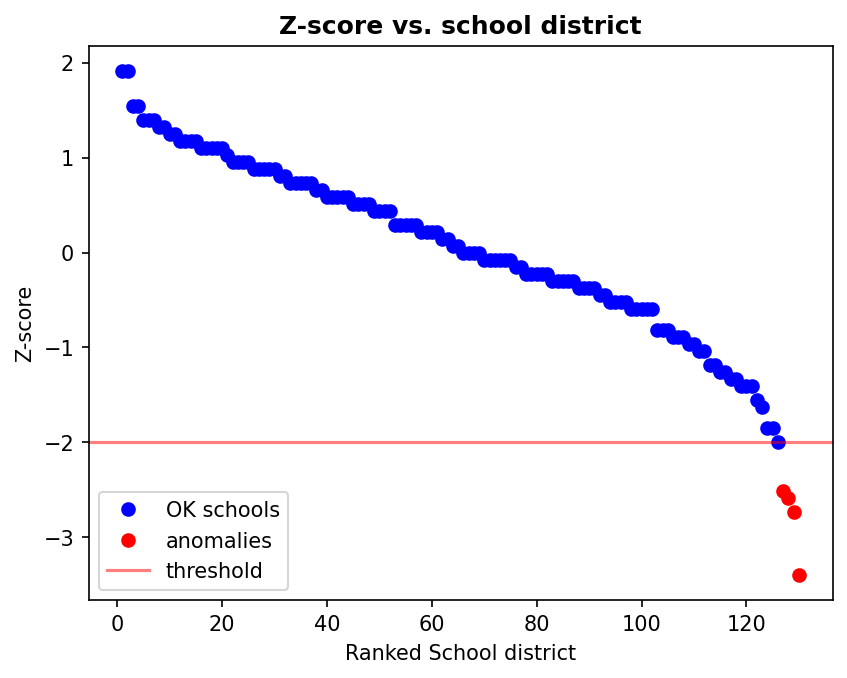

In [7]:
plot_anomaly(ct_test['zscore'], -2)

#### Нарешті, отримайте список шкіл, які є аномаліями.

In [8]:
zscore_anomalies = ct_test[(ct_test['zscore'] < -2)]
zscore_anomalies

,District,Participation Rate,zscore
50,New Britain,0.40,-2.510660
99,Windham,0.37,-2.731839
121,Eastern Connecticut Regional Educational Servi...,0.39,-2.584386
125,Stamford Academy,0.28,-3.395374


Ми знайшли свої аномалії, але нам все ще залишається зробити одне: перевірити наше припущення, що дані можна моделювати з наближенням як нормальний розподіл. Якщо це так, то ми завершили наш тест. Якщо це не так, ми не можемо пов’язати z-оцінку з імовірностями, як ми робили раніше в цьому файлі.

#### По-перше, давайте об’єднаємо дані та подивимось, як це виглядає як гістограма.

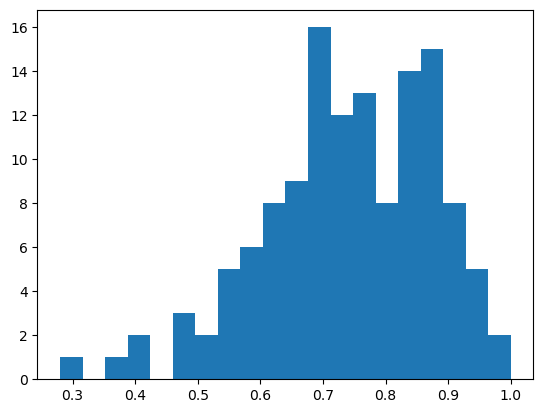

In [9]:
nbins= 20
n_hist, bins_hist, patches_hist = plt.hist(ct_test['Participation Rate'], nbins, density=False,
                           cumulative=False, linewidth=1.0, label='data')

Ця гістограма має два максимуми та зміщена вліво, тому навряд чи буде нормальною.

##### Ми також можемо порівняти кумулятивну функцію розподілу (CDF) для наших даних із CDF нормального розподілу з тим самим середнім і стандартним відхиленням наших даних.

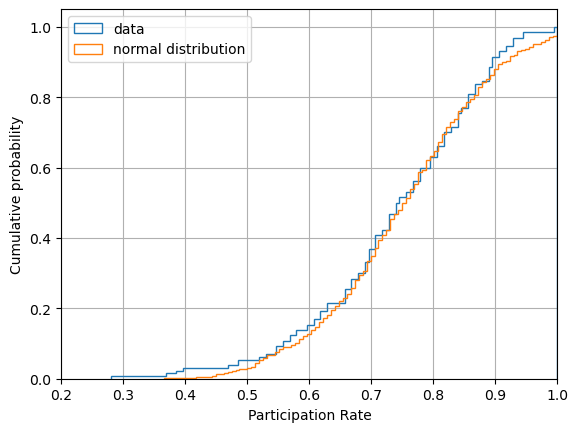

In [10]:
num_bins = 130
plt.hist(ct_test['Participation Rate'], num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=1.0, label='data')
normal_dist = [random.gauss(mean_rate, stdev_rate) for _ in range(500)]
plt.hist(normal_dist, num_bins, density=True, histtype='step',
                           cumulative=True, linewidth=1.0, label='normal distribution')
plt.grid(True) #додати лінії сітки до графіка
plt.legend(loc='upper left')
axes = plt.gca() #Отримайте поточні осі
axes.set_xlim([0.2,1.0])
plt.xlabel('Participation Rate')
plt.ylabel('Cumulative probability')
plt.show()

Знову ж таки, ми бачимо різницю. Якби ці два візуальні тести не були вирішальними, ми могли б провести чисельний тест на нормальність (наприклад, тест Шапіро-Вілка, або інший тест).

Незважаючи на те, що наші дані не відповідають нормальному розподілу, як z-показник, так і модифікований z-показник допомогли нам визначити викиди. Таким чином, хоча ми не можемо робити жодних ймовірнісних прогнозів на основі z-показників, ми можемо з упевненістю зосередитися на цих чотирьох школах.

# Розділ 3: Порівняння Z-оцінки  з модифікованою Z-оцінкою — найкращі бомбардири чемпіонату світу¶
Тепер ми розглянемо набір даних, який показує обмеження z-оцінки і чому модифікована z-оцінка може бути корисною.

Ми розглянемо кількість голів, забитих кращим бомбардиром на кожному Чемпіонаті світу з 1930 по 2018 рік (загалом 21 змагання). Необроблені дані звідси:

https://en.wikipedia.org/wiki/FIFA_World_Cup_part_ratecorers

Дані були очищені та збережені як CSV. 
#### Завантажте його як датафрейм і подивіться.

In [ ]:
# Перший рядок – це рядок заголовка, але імена заголовків громіздкі.
# Пропустіть перший рядок (skiprows=1) і позначте вручну
# Кодування гарантує правильне відображення наголосів у самих іменах футболістів 
top_goals = pd.read_csv('world_cup_top_goal_scorers.csv', 
                        encoding='utf-8',  
                        names=['Year', 'Player(s)', 'Goals'], skiprows=1)                                                                                
top_goals.head()

,Year,Player(s),Goals
0,1930,Guillermo Stábile,8
1,1934,Oldřich Nejedlý,5
2,1938,Leônidas,7
3,1950,Ademir,8
4,1954,Sándor Kocsis,11
5,1958,Just Fontaine,13
6,1962,"Garrincha, Vavá, Leonel Sánchez, Flórián Alber...",4
7,1966,Eusébio,9
8,1970,Gerd Müller,10
9,1974,Grzegorz Lato,7


Знову використаємо z-оцінку для виявлення аномалій. Оскільки нас цікавлять суперзірки, цього разу у нас буде верхній поріг. Обираємо 𝑧=+2. Вище цієї z-оцінки будь-який гравець буде позначений як аномалія.

Як і раніше, ми обчислюємо середнє значення та стандартне відхилення.

In [12]:
mean_goals = top_goals['Goals'].mean()
stdev_goals = top_goals['Goals'].std(ddof=0)
print('Mean number of goals is {:.2f}'.format(mean_goals))
print('Standard deviation is {:.2f}'.format(stdev_goals))

Mean number of goals is 7.05
Standard deviation is 2.15


#### Обчисліть z-оцінку для кожного гравця та додайте результат до набору даних.

In [13]:
zscore_goals = ss.zscore(top_goals['Goals'], ddof=0)
top_goals = top_goals.assign(zscore=zscore_goals)
top_goals.head(21)

,Year,Player(s),Goals,zscore
0,1930,Guillermo Stábile,8,0.443242
1,1934,Oldřich Nejedlý,5,-0.952971
2,1938,Leônidas,7,-0.022162
3,1950,Ademir,8,0.443242
4,1954,Sándor Kocsis,11,1.839455
5,1958,Just Fontaine,13,2.770264
6,1962,"Garrincha, Vavá, Leonel Sánchez, Flórián Alber...",4,-1.418375
7,1966,Eusébio,9,0.908647
8,1970,Gerd Müller,10,1.374051
9,1974,Grzegorz Lato,7,-0.022162


#### Тепер змініть попередню функцію побудови для відображення результатів.

In [14]:
def plot_anomaly_goals(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outlier = (score_data > threshold)
    
    plt.figure(dpi=100)
    plt.plot(ranks[mask_outlier], score_data[mask_outlier], 'o', color='r', label='anomalies')
    plt.plot(ranks[~mask_outlier], score_data[~mask_outlier], 'o', color='b', label='typical player')
    plt.axhline(threshold,color='r', label='threshold', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title('Z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player Rank')
    plt.ylabel('Z-score')
    plt.show()

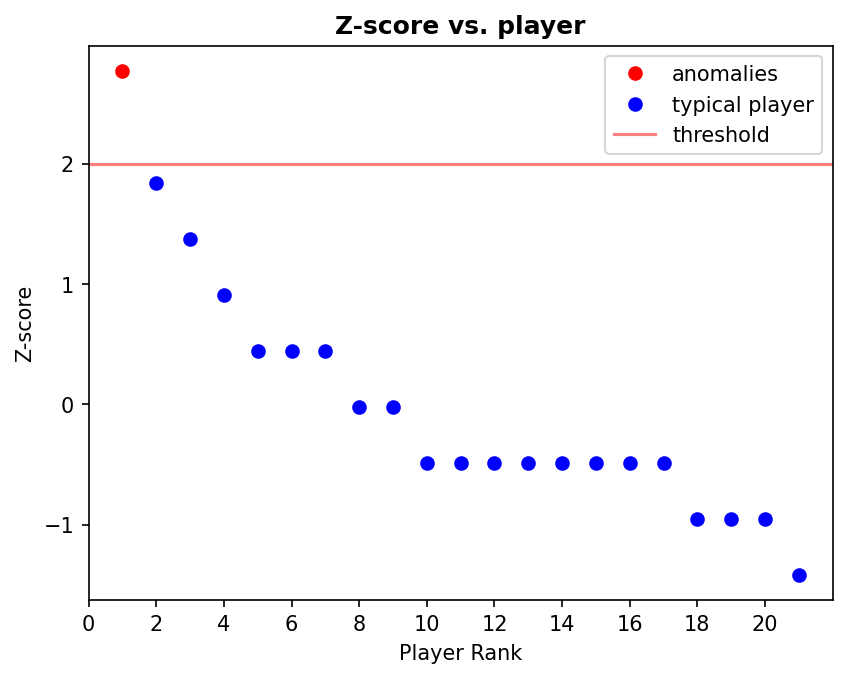

In [15]:
plot_anomaly_goals(top_goals['zscore'], 2)

Вибирається лише один гравець: Джаст Фонтейн.

In [16]:
zscore_anomalies_players = top_goals[(top_goals['zscore'] > 2)]
zscore_anomalies_players

,Year,Player(s),Goals,zscore
5,1958,Just Fontaine,13,2.770264


Фонтейн справді був чудовим гравцем, але очевидно, що наш аналіз помилковий. Дивлячись на графік, ми бачимо, що у 12 із 21 змагань найкращий бомбардир(и) забили менше, ніж середня кількість голів (7,05).

Питання: Що відбувається?

Відповідь: ми бачимо ефект, який ми обговорювали на лекціях --- середнє значення та стандартне відхилення самі по собі чутливі до наявності аномалій. Завдяки своїм 13 голам дивовижний Фонтейн настільки підвищує середнє значення, що більшість гравців опускається нижче. В результаті він стає єдиною аномалією.

#### Давайте повторимо цей аналіз із зміненим z-показником і подивимося, що станеться.

In [17]:
median_goals = np.median(top_goals['Goals'])
median_goals

6.0

Зауважте, що медіана (6,0) нижча за середнє значення (7,05), як і очікувалося на графіку.

Тепер обчисліть модифікований z-показник. Згадайте, що на лекціях це було визначено для кожної точки даних 𝑥𝑖 наступним чином:

𝑦𝑖=(𝑥𝑖−𝑋̃ )/МАD

де 𝑋̃ — медіана даних, а MAD — медіана абсолютного відхилення від медіани.

Тут ми внесемо невелику модифікацію та введемо поправку узгодженості 𝑘, яка дозволить нам використовувати MAD як узгоджену оцінку для стандартного відхилення. Значення 𝑘
  залежить від основного розподілу даних. Для простоти ми будемо використовувати значення для нормального розподілу 𝑘=1,4826
  (див.https://uk.wikipedia.org/wiki/%D0%9C%D0%B5%D0%B4%D1%96%D0%B0%D0%BD%D0%B0_%D0%B0%D0%B1%D1%81%D0%BE%D0%BB%D1%8E%D1%82%D0%BD%D0%B8%D1%85_%D0%B2%D1%96%D0%B4%D1%85%D0%B8%D0%BB%D0%B5%D0%BD%D1%8C
  
  https://en.wikipedia.org/wiki/Median_absolute_deviation).

Примітка. Коригувальний коефіцієнт 𝑘=1,4826 передбачає, що базові дані є нормальними!

Отже, модифікована z-оцінка стає

𝑦𝑖=(𝑥𝑖−𝑋̃ )/(𝑘∗MAD)

і це форма, яку ми будемо використовувати у функції нижче.

In [18]:
def modified_zscore(data, consistency_correction=1.4826):
    """
    Повертає модифікований z-оцінку та середнє абсолютне відхилення (MAD) із оцінок у даних.
     Коефіцієнт поправки консистенції перетворює MAD на стандартне відхилення для даного розподілу. 
     Значення за замовчуванням (1,4826) є коефіцієнтом перетворення, якщо базові дані розподілені нормально
    """
    median = np.median(data)
    
    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    return mod_zscore, mad

#### Як і раніше, обчисліть модифікований z-рахунок для всіх гравців, а потім побудуйте та перелічіть результати. Зауважте, що поріг залишається незмінним і становить 𝑦=+2.

In [19]:
mod_zscore_goals, mad_goals = modified_zscore(top_goals['Goals'])
top_goals = top_goals.assign(mod_zscore=mod_zscore_goals)

In [20]:
def plot_anomaly_goals_2(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outliers = (score_data > threshold)
    
    plt.figure(dpi=100)
    plt.plot(ranks[mask_outliers], score_data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], score_data[~mask_outliers],'o', color='b', label='typical player')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. player', fontweight='bold')
    plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Player')
    plt.ylabel('Modified z-score')
    plt.show()

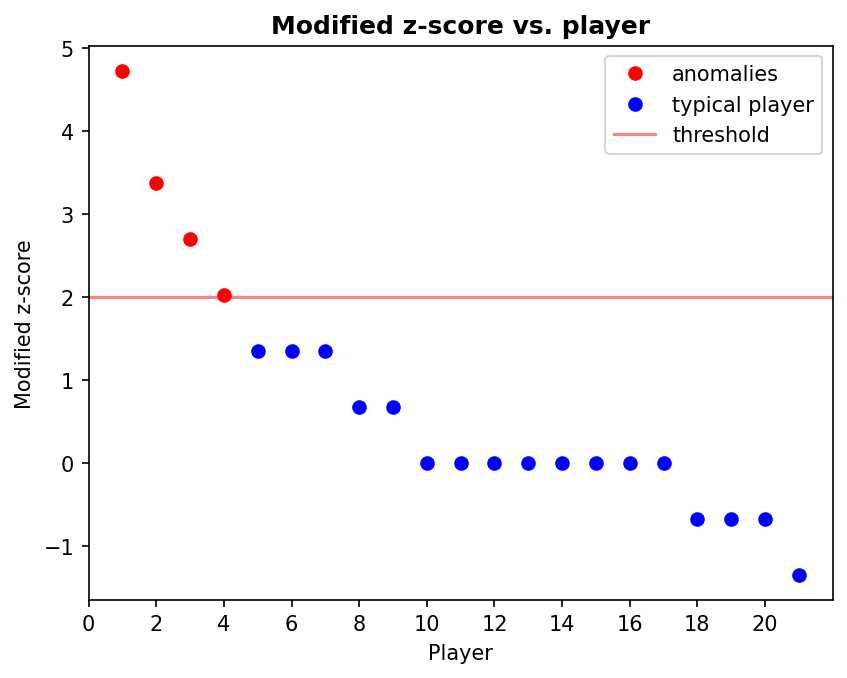

In [21]:
plot_anomaly_goals_2(top_goals['mod_zscore'], 2)

In [22]:
mod_zscore_anomalies_players = top_goals[(top_goals['mod_zscore'] > 2)]
mod_zscore_anomalies_players

,Year,Player(s),Goals,zscore,mod_zscore
4,1954,Sándor Kocsis,11,1.839455,3.372454
5,1958,Just Fontaine,13,2.770264,4.721435
7,1966,Eusébio,9,0.908647,2.023472
8,1970,Gerd Müller,10,1.374051,2.697963


Тепер ми знаходимо чотирьох аномальних гравців.

##### Запитання: Як MAD порівнюється зі стандартним відхиленням, розрахованим раніше?

##### Відповідь:

In [23]:
print('The value of MAD is {:.2f}'.format(mad_goals))
print('Standard deviation is {:.2f}'.format(stdev_goals))

The value of MAD is 1.00
Standard deviation is 2.15


Видно, що 𝑘∗MAD = 1,48, що менше, ніж стандартне відхилення (2,15). Ми бачимо, що аномалії мають більший вплив на стандартне відхилення, яке залежить від квадрата відхилення від середнього (MAD лінійно залежить від відхилення).

Звичайно, дані про найкращих бомбардирів розподіляються ненормально, тому ми не можемо пов’язати ймовірності з нашими результатами, але наш аналіз показує, що потрібно подумати про метод оцінки, який використовується з даними.

# Ітераційне застосування тесту Граббса для кількох викидів:
Тест Ґраббса призначений для перевірки одного викиду за раз у нормально розподілених наборах даних. Це означає, що якщо в наборі даних є більше одного викиду, тест Ґраббса визначить лише найбільш екстремальний.

Якщо ви підозрюєте, що у вашому наборі даних може бути кілька викидів, ви можете повторно застосувати тест Граббса. На кожній ітерації ви видаляєте найбільший викид, виявлений тестом (за умови, що тест вказує, що це справді викид), а потім повторно застосовуєте тест до решти даних. Цей процес можна продовжувати, доки не буде виявлено подальших викидів.

Однак майте на увазі, що ця ітераційна процедура може збільшити ймовірність помилки типу I (хибні спрацьовування), особливо якщо набір даних великий або якщо кількість справжніх викидів невелика. Це пояснюється тим, що чим більше тестів ви виконуєте, тим більша ймовірність того, що ви випадково знайдете «викид». Тому, якщо ви плануєте використовувати тест Ґраббса ітеративно, важливо використовувати відповідний метод для контролю частоти помилок на основі сімейства, наприклад поправку Бонферроні.

# Тест Граббса для виявлення викидів
Тест Ґраббса — це статистичний тест, який використовується для виявлення викидів в одновимірному наборі даних, який, як припускається, походить від нормально розподіленої сукупності.

Тест працює шляхом обчислення статистики (G), яка базується на вибірковому середньому, вибірковому стандартному відхиленні та абсолютній різниці між вибірковим середнім значенням і кожним окремим спостереженням. Спостереження, що відповідає максимальному (G) значенню, є потенційним викидом.

Формула статистики Граббса така:


$$
G = \frac{{\max_{i=1}^n |Y_i - \bar{Y}|}}{s}
$$
 
де:

$Y_i$ є i-м спостереженням,
- $\bar{Y}$ вибіркове середнє,
- $s$ стандартне відхилення вибірки,
- $n$  – кількість спостережень.
   
  
Нульова гіпотеза полягає в тому, що в наборі даних немає викидів. Велике значення (G) свідчить про те, що відповідне спостереження є викидом. Тест зазвичай виконується на рівні значущості 0,05, що означає, що нульову гіпотезу відхиляють (і спостереження оголошують викидом), якщо р-значення тесту менше 0,05.

Ось покроковий процес:

Обчисліть вибіркове середнє та стандартне відхилення. За вибіркою з n спостережень обчисліть вибіркове середнє (середнє) і стандартне відхилення вибірки. Середнє значення вибірки розраховується як:

$$
   \bar{Y} = \frac{1}{n} \sum_{i=1}^{n} Y_i
   $$
 
стандартне відхилення вибірки обчислюється як:

$$
   s = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n} (Y_i - \bar{Y})^2}
   $$
 
де 𝑌𝑖
   є i-м спостереженням.

Обчисліть абсолютне відхилення кожного спостереження від середнього значення вибірки. За кожне спостереження 𝑌𝑖
  , обчислити абсолютне відхилення від вибіркового середнього,  $|Y_i - \bar{Y}|$.

Обчисліть статистику Граббса. Статистика Граббса, G, є максимальним абсолютним відхиленням, поділеним на стандартне відхилення вибірки:

$$
   G = \frac{{\max_{i=1}^n |Y_i - \bar{Y}|}}{s}
   $$
 
Обчисліть критичне значення. Критичне значення обчислюється з t-розподілу з 𝑛−2
   ступенів свободи та рівень значущості 𝛼/𝑛
  . Формула така:

 $$
   G_{crit} = \frac{(n-1)\sqrt{t_{\alpha/(2n), n-2}^2}}{\sqrt{n(t_{\alpha/(2n), n-2}^2 + n - 2)}}
   $$
 
де 𝑡𝛼/(2𝑛),𝑛−2
   є критичним значенням t-розподілу з 𝑛−2
   ступенів свободи та рівень значущості 𝛼/𝑛
  .

Порівняйте статистику Граббса з критичним значенням. Якщо 𝐺>𝐺𝑐𝑟𝑖𝑡
  , тоді нульова гіпотеза про відсутність викидів відхиляється, а спостереження, яке відповідає максимальному абсолютному відхиленню, оголошується викидом.

Припущення та обмеження
Хоча тест Граббса є корисним інструментом для виявлення окремих викидів, він має свої обмеження:

Тест передбачає, що дані розподілені нормально. Це припущення можна оцінити за допомогою тесту нормальності, такого як тест Шапіро-Вілка.
Тест Граббса зазвичай перевіряє лише один викид за раз. Тест призначений для ітераційного використання, тестування та видалення одного викиду за раз. Однак майте на увазі, що кожного разу, коли ви використовуєте тест, ви фактично збільшуєте рівень альфа (тобто ймовірність помилки типу I). Тому будьте обережні, якщо плануєте використовувати тест Граббса ітеративно.
Викиди слід видаляти, лише якщо їх можна об’єктивно та науково пояснити. Вони можуть виникати через помилки введення даних, помилки вимірювання або інші явища. Не видаляйте викиди лише для досягнення більш бажаного статистичного результату.

In [24]:
# Define Grubbs' Test function
def grubbs_test(data, alpha=0.05):
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = (data - mean) / std_dev
    abs_z_scores = np.abs((data - mean) / std_dev)
    max_z_score = np.max(abs_z_scores)
    max_z_score_index = np.argmax(abs_z_scores)
    
    print(f"Number of data points: {n}")
    print(f"Mean of data: {mean}")
    print(f"Standard Deviation of data: {std_dev}")
    print("\nZ-Scores")
    print(z_scores)
    print(f"Max Absolute Z-Score: {max_z_score} located at index {max_z_score_index}\n")

    # Calculate the Grubbs' Test statistic
    G_calculated = (n-1) * np.sqrt(max_z_score**2 / (n-2+max_z_score**2))

    # Look up the critical value of the Grubbs' Test statistic from the t-distribution
    t_critical = ss.t.ppf(1 - alpha / (2*n), n-2)
    G_critical = ((n-1) / np.sqrt(n)) * np.sqrt(t_critical**2 / (n-2 + t_critical**2))

    # If the calculated test statistic is larger than the critical value, then reject the null hypothesis and mark the data point as an outlier
    if G_calculated > G_critical:
        print(f"Outlier detected at index {max_z_score_index}.")
        outlier = True
    else:
        print("No outliers detected.")
        outlier = False

    return max_z_score_index, outlier

In [25]:
# Call the Grubbs' Test function on our data
outlier_index, is_outlier = grubbs_test(top_goals['Goals'])

Number of data points: 21
Mean of data: 7.0476190476190474
Standard Deviation of data: 2.1486693662244725

Z-Scores
0     0.443242
1    -0.952971
2    -0.022162
3     0.443242
4     1.839455
5     2.770264
6    -1.418375
7     0.908647
8     1.374051
9    -0.022162
10   -0.487566
11   -0.487566
12   -0.487566
13   -0.487566
14   -0.487566
15   -0.487566
16    0.443242
17   -0.952971
18   -0.952971
19   -0.487566
20   -0.487566
Name: Goals, dtype: float64
Max Absolute Z-Score: 2.770263794862101 located at index 5

Outlier detected at index 5.


In [26]:
top_goals[['Player(s)','Goals']].iloc[outlier_index]

Player(s)    Just Fontaine
Goals                   13
Name: 5, dtype: object

Тест Грабса також знайшов аномальне значення для футболіста Just Fontaine

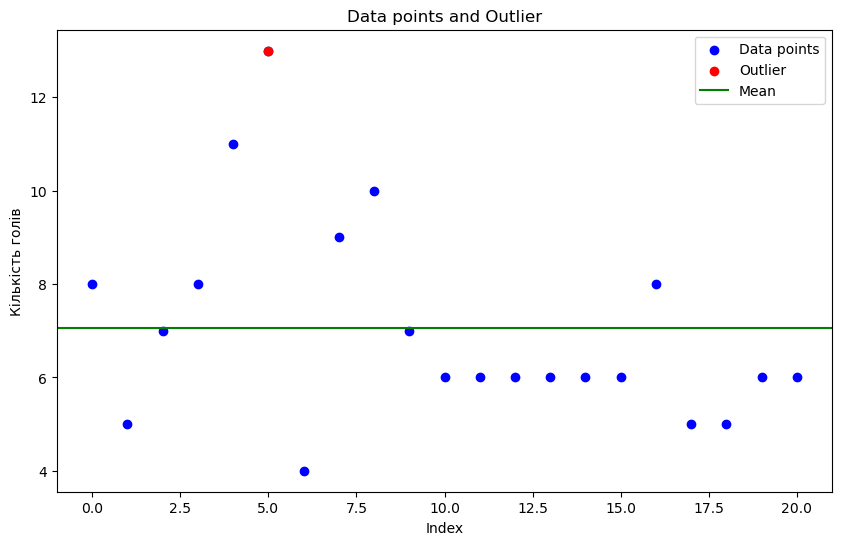

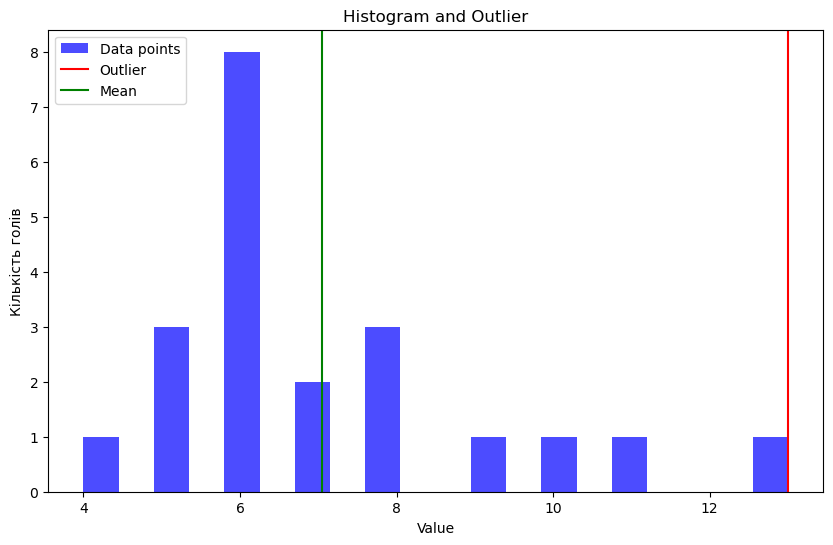

In [27]:
# Create a scatter plot of the data
plt.figure(figsize=(10, 6))
plt.scatter(range(len(top_goals['Goals'])), top_goals['Goals'], color='blue', label='Data points')
if is_outlier:
    plt.scatter(outlier_index, top_goals['Goals'][outlier_index], color='red', label='Outlier')
plt.axhline(y=np.mean(top_goals['Goals']), color='green', linestyle='-', label='Mean')
plt.legend()
plt.title('Data points and Outlier')
plt.xlabel('Index')
plt.ylabel('Кількість голів')
plt.show()

# Create a histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(top_goals['Goals'], bins=20, color='blue', alpha=0.7, label='Data points')
if is_outlier:
    plt.axvline(x=top_goals['Goals'][outlier_index], color='red', linestyle='-', label='Outlier')
plt.axvline(x=np.mean(top_goals['Goals']), color='green', linestyle='-', label='Mean')
plt.legend()
plt.title('Histogram and Outlier')
plt.xlabel('Value')
plt.ylabel('Кількість голів')
plt.show()

## Виявлення багатовимірних викидів за допомогою відстані Махаланобіса¶


Відстань Махаланобіса — це міра відстані між точкою 𝑃
   і множиною 𝐷
  . Це багатовимірне узагальнення ідеї вимірювання кількості стандартних відхилень 𝑃
   від середнього 𝐷
  .

За точкою 𝑃    з координатами $(x_1, x_2, ..., x_n)$    в 𝑛
  -вимірному просторі, відстань Махаланобіса $D_M$    з 𝑃
   до центру набору точок обчислюється як:

$$
D_M = \sqrt{ (P - \mu)^T \Sigma^{-1} (P - \mu) }
$$
 
де:

𝑃
   – точковий вектор,
𝜇
   – середній вектор розподілу,
Σ
   є коваріаційною матрицею розподілу, і
𝑇
   позначає матричне транспонування.
Відстань Махаланобіса враховує кореляції набору даних і є масштабно-інваріантною. На відміну від евклідової відстані, вона враховує дисперсію та коваріацію кількох змінних.

#### Тест на відстань Махаланобіса

Відстань Махаланобіса можна використовувати в перевірці гіпотези, тесті відстані Махаланобіса, для виявлення багатофакторних викидів.

Для точок вибірки розміру 𝑛 з 𝑝 ознаками (координатами) квадрат відстані Махаланобіса $D_M^2$
 відповідає розподілу хі-квадрат із 𝑝   ступенями свободи за нульовою гіпотезою, тобто точка відповідає розподілу. Отже, якщо обчислене $D_M^2$    перевищує критичне значення розподілу хі-квадрат для бажаного рівня значущості (наприклад, 0,05), ми відхиляємо нульову гіпотезу.

Процедура перевірки гіпотези така:

1. Обчисліть відстань Махаланобіса $D_M^2$ для відповідної точки.

2. Визначте критичне значення хі-квадрат для 𝑝    ступені свободи та бажаний рівень значущості.

3. Якщо $D_M^2$   > критичного значення,тоді  точка вважається викидом.

Цей тест може бути дуже корисним на практиці для виявлення викидів у багатовимірних даних.

In [28]:
from scipy.stats import chi2
from sklearn.covariance import EmpiricalCovariance

In [29]:
# Визначте багатовимірні дані
data = np.array([[100000, 16000, 300, 60, 76],
                 [800000, 60000, 400, 88, 89],
                 [650000, 300000, 1230, 90, 89],
                 [700000, 10000, 300, 87, 57],
                 [860000, 252000, 400, 83, 79],
                 [730000, 350000, 104, 81, 84],
                 [400000, 260000, 632, 72, 78],
                 [20, 260000, 6302, 2, 2000],
                 [870000, 510000, 221, 91, 99],
                 [780000, 2000, 142, 90, 97],
                 [400000, 5000, 267, 93, 99]])

# Create a DataFrame
columns = ['Price', 'Distance', 'Emission', 'Performance', 'Mileage']
df = pd.DataFrame(data, columns=columns)

print(f"Data:\n{df}\n")

Data:
     Price  Distance  Emission  Performance  Mileage
0   100000     16000       300           60       76
1   800000     60000       400           88       89
2   650000    300000      1230           90       89
3   700000     10000       300           87       57
4   860000    252000       400           83       79
5   730000    350000       104           81       84
6   400000    260000       632           72       78
7       20    260000      6302            2     2000
8   870000    510000       221           91       99
9   780000      2000       142           90       97
10  400000      5000       267           93       99



In [30]:
def calculateMahalanobis(data):
    robust_cov = EmpiricalCovariance().fit(data)
    m_dist = robust_cov.mahalanobis(data)
    return m_dist

In [ ]:
# Обчисліть відстані Махаланобіса
m_dist = calculateMahalanobis(df)

print(f"Відстані Махаланобіса:\n{m_dist}\n")

# Визначте рівень значущості для виявлення викидів
alpha = 0.10

# Cобчислити порогове значення (на основі розподілу хі-квадрат)
thresh = chi2.ppf(1 - alpha, df=df.shape[1])

print(f"Поріг для виявлення викидів: {thresh}\n")

# Виявлення викидів (де відстань Махаланобіса перевищує порогове значення)
outliers = df[m_dist > thresh]
df['distance'] = m_dist
df['outlier'] = df['distance'] > thresh

print(f"Аномалії:\n{outliers}")

print(f"Дані:\n{df}\n")

Mahalanobis distances:
[7.23782241 2.22109829 8.21440824 1.89413229 2.57169465 2.83641857
 2.70941648 9.99763797 6.10733273 3.03153561 8.17850277]

Threshold for outlier detection: 9.236356899781123

Outliers:
   Price  Distance  Emission  Performance  Mileage
7     20    260000      6302            2     2000
Data:
     Price  Distance  Emission  Performance  Mileage  distance  outlier
0   100000     16000       300           60       76  7.237822    False
1   800000     60000       400           88       89  2.221098    False
2   650000    300000      1230           90       89  8.214408    False
3   700000     10000       300           87       57  1.894132    False
4   860000    252000       400           83       79  2.571695    False
5   730000    350000       104           81       84  2.836419    False
6   400000    260000       632           72       78  2.709416    False
7       20    260000      6302            2     2000  9.997638     True
8   870000    510000       221    

# Вправа №1¶
Ця вправа стосується рівня участі в SAT.

A. Повторіть аналіз, використовуючи модифіковану z-оцінку.

Б. Повторіть аналіз, використовуючи тест Граббса. Застосуйте тест Граббса чотири рази, видаляючи на кожному кроці рядок даних з аномалією.

С. Ви знаходите однакові аномалії? Порівняйте знайдені аномалії, які отрмали при застосуванні z-оцінки, модифікованої z-оцінки, тесту Граббса.

D. Зробіть свої висновки.

#### Розв'язок #1

Mean rates are 0.74
Standard deviation is 0.14


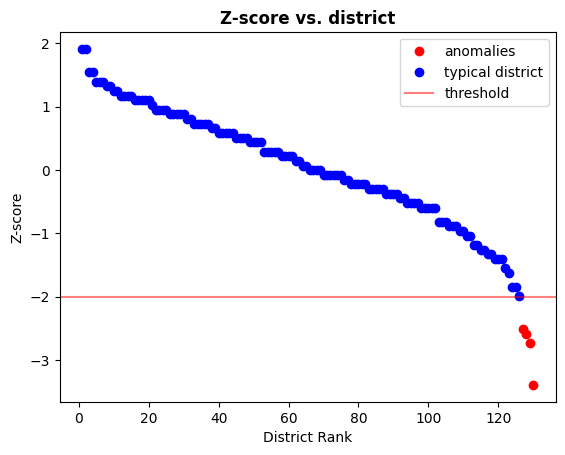

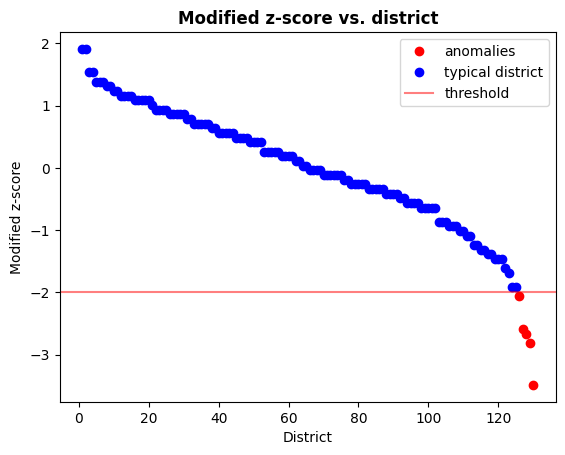

In [1]:
import sys
import scipy
import scipy.stats as ss
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random

part_rate = pd.read_csv('SAT_CT_District_Participation_2012.csv', 
                        encoding='utf-8',  
                        names=['District', 'Participation Rate'], skiprows=1)                                                                                

part_rate.head(129)

mean_rates = part_rate['Participation Rate'].mean()
stdev_rates = part_rate['Participation Rate'].std(ddof=0)
print('Mean rates are {:.2f}'.format(mean_rates))
print('Standard deviation is {:.2f}'.format(stdev_rates))

zscore_rates = ss.zscore(part_rate['Participation Rate'], ddof=0)
part_rate = part_rate.assign(zscore=zscore_rates)
part_rate.head(129)

def plot_anomaly_rates(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outliers = (score_data < threshold)
    
    plt.figure(dpi=100)
    plt.plot(ranks[mask_outliers], score_data[mask_outliers], 'o', color='r', label='anomalies')
    plt.plot(ranks[~mask_outliers], score_data[~mask_outliers], 'o', color='b', label='typical district')
    plt.axhline(threshold, color='r', label='threshold', alpha=0.5)
    plt.legend(loc='upper right')
    plt.title('Z-score vs. district', fontweight='bold')
    plt.xlabel('District Rank')
    plt.ylabel('Z-score')
    plt.show()

plot_anomaly_rates(part_rate['zscore'], -2)

zscore_anomalies_rates = part_rate[(part_rate['zscore'] < -2)]
zscore_anomalies_rates

median_rate = np.median(part_rate['Participation Rate'])
median_rate

def modified_zscore(data, consistency_correction=1.4826):
    """
    Повертає модифікований z-оцінку та середнє абсолютне відхилення (MAD) із оцінок у даних.
     Коефіцієнт поправки консистенції перетворює MAD на стандартне відхилення для даного розподілу. 
     Значення за замовчуванням (1,4826) є коефіцієнтом перетворення, якщо базові дані розподілені нормально
    """
    median = np.median(data)
    
    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    return mod_zscore, mad

mod_zscore_rates, mad_rates = modified_zscore(part_rate['Participation Rate'])
part_rate = part_rate.assign(mod_zscore=mod_zscore_rates)

def plot_anomaly_rates_2(score_data, threshold):
    score_data = score_data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(score_data), len(score_data))
    mask_outliers = (score_data < threshold)
    
    plt.figure(dpi=100)
    plt.plot(ranks[mask_outliers], score_data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], score_data[~mask_outliers],'o', color='b', label='typical district')
    plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. district', fontweight='bold')
    plt.xlabel('District')
    plt.ylabel('Modified z-score')
    plt.show()

plot_anomaly_rates_2(part_rate['mod_zscore'], -2)

In [3]:
mod_zscore_anomalies_rates = part_rate[(part_rate['mod_zscore'] < -2.1)]
mod_zscore_anomalies_rates

print('The value of MAD is {:.2f}'.format(mad_rates))
print('Standard deviation is {:.2f}'.format(stdev_rates))

The value of MAD is 0.09
Standard deviation is 0.14


                                              District  Participation Rate  \
125                                   Stamford Academy                0.28   
99                                             Windham                0.37   
121  Eastern Connecticut Regional Educational Servi...                0.39   
50                                         New Britain                0.40   

       zscore  mod_zscore  
125 -3.395374   -3.484869  
99  -2.731839   -2.810378  
121 -2.584386   -2.660491  
50  -2.510660   -2.585548  


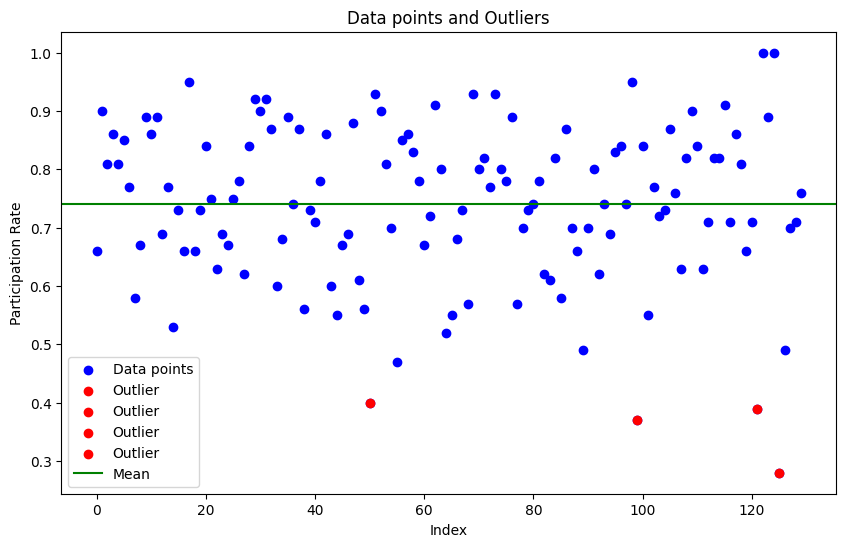

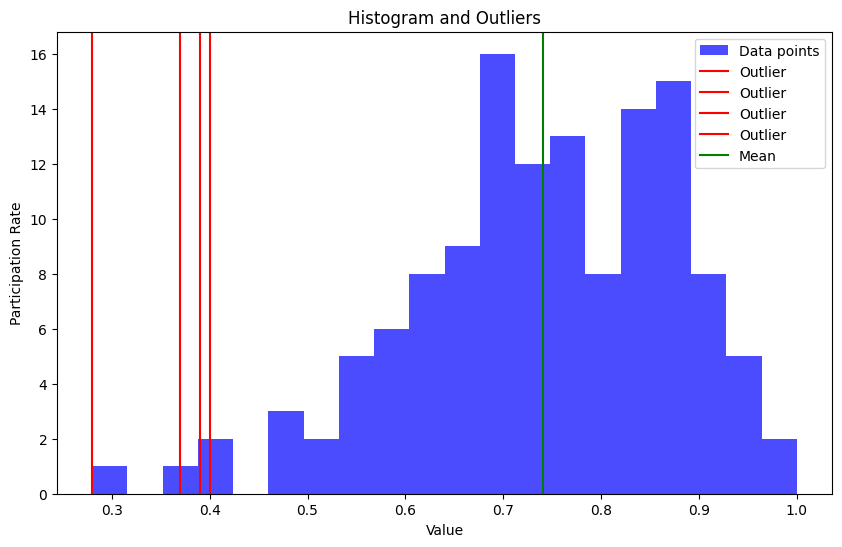

In [3]:
# Define Grubbs' Test function
def grubbs_test(data, alpha=0.05):
    n = len(data)
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = (data - mean) / std_dev
    abs_z_scores = np.abs((data - mean) / std_dev)
    max_z_score = np.max(abs_z_scores)
    max_z_score_index = np.argmax(abs_z_scores)
    
    # Calculate the Grubbs' Test statistic
    G_calculated = (n-1) * np.sqrt(max_z_score**2 / (n-2+max_z_score**2))

    # Look up the critical value of the Grubbs' Test statistic from the t-distribution
    t_critical = ss.t.ppf(1 - alpha / (2*n), n-2)
    G_critical = ((n-1) / np.sqrt(n)) * np.sqrt(t_critical**2 / (n-2 + t_critical**2))

    # If the calculated test statistic is larger than the critical value, then reject the null hypothesis and mark the data point as an outlier
    if G_calculated > G_critical:
        outlier = True
    else:
        outlier = False

    return max_z_score_index, outlier

# Repeat Grubbs' Test four times, removing the outlier each time
part_rate_copy = part_rate.copy()
outliers = []

for _ in range(4):
    outlier_index, is_outlier = grubbs_test(part_rate_copy['Participation Rate'])
    if is_outlier:
        outliers.append(part_rate_copy.iloc[outlier_index])
        part_rate_copy = part_rate_copy.drop(part_rate_copy.index[outlier_index])
    else:
        break

# Convert the list of outliers to a DataFrame
grubbs_anomalies_rates = pd.DataFrame(outliers)

# Display the outliers found by Grubbs' Test
print(grubbs_anomalies_rates)

# Create a scatter plot of the data
plt.figure(figsize=(10, 6))
plt.scatter(range(len(part_rate['Participation Rate'])), part_rate['Participation Rate'], color='blue', label='Data points')
for outlier in outliers:
    plt.scatter(part_rate[part_rate['District'] == outlier['District']].index, outlier['Participation Rate'], color='red', label='Outlier')
plt.axhline(y=np.mean(part_rate['Participation Rate']), color='green', linestyle='-', label='Mean')
plt.legend()
plt.title('Data points and Outliers')
plt.xlabel('Index')
plt.ylabel('Participation Rate')
plt.show()

# Create a histogram of the data
plt.figure(figsize=(10, 6))
plt.hist(part_rate['Participation Rate'], bins=20, color='blue', alpha=0.7, label='Data points')
for outlier in outliers:
    plt.axvline(x=outlier['Participation Rate'], color='red', linestyle='-', label='Outlier')
plt.axvline(x=np.mean(part_rate['Participation Rate']), color='green', linestyle='-', label='Mean')
plt.legend()
plt.title('Histogram and Outliers')
plt.xlabel('Value')
plt.ylabel('Participation Rate')
plt.show()